# Utility Program for projecting maps and calculating FFT for projects

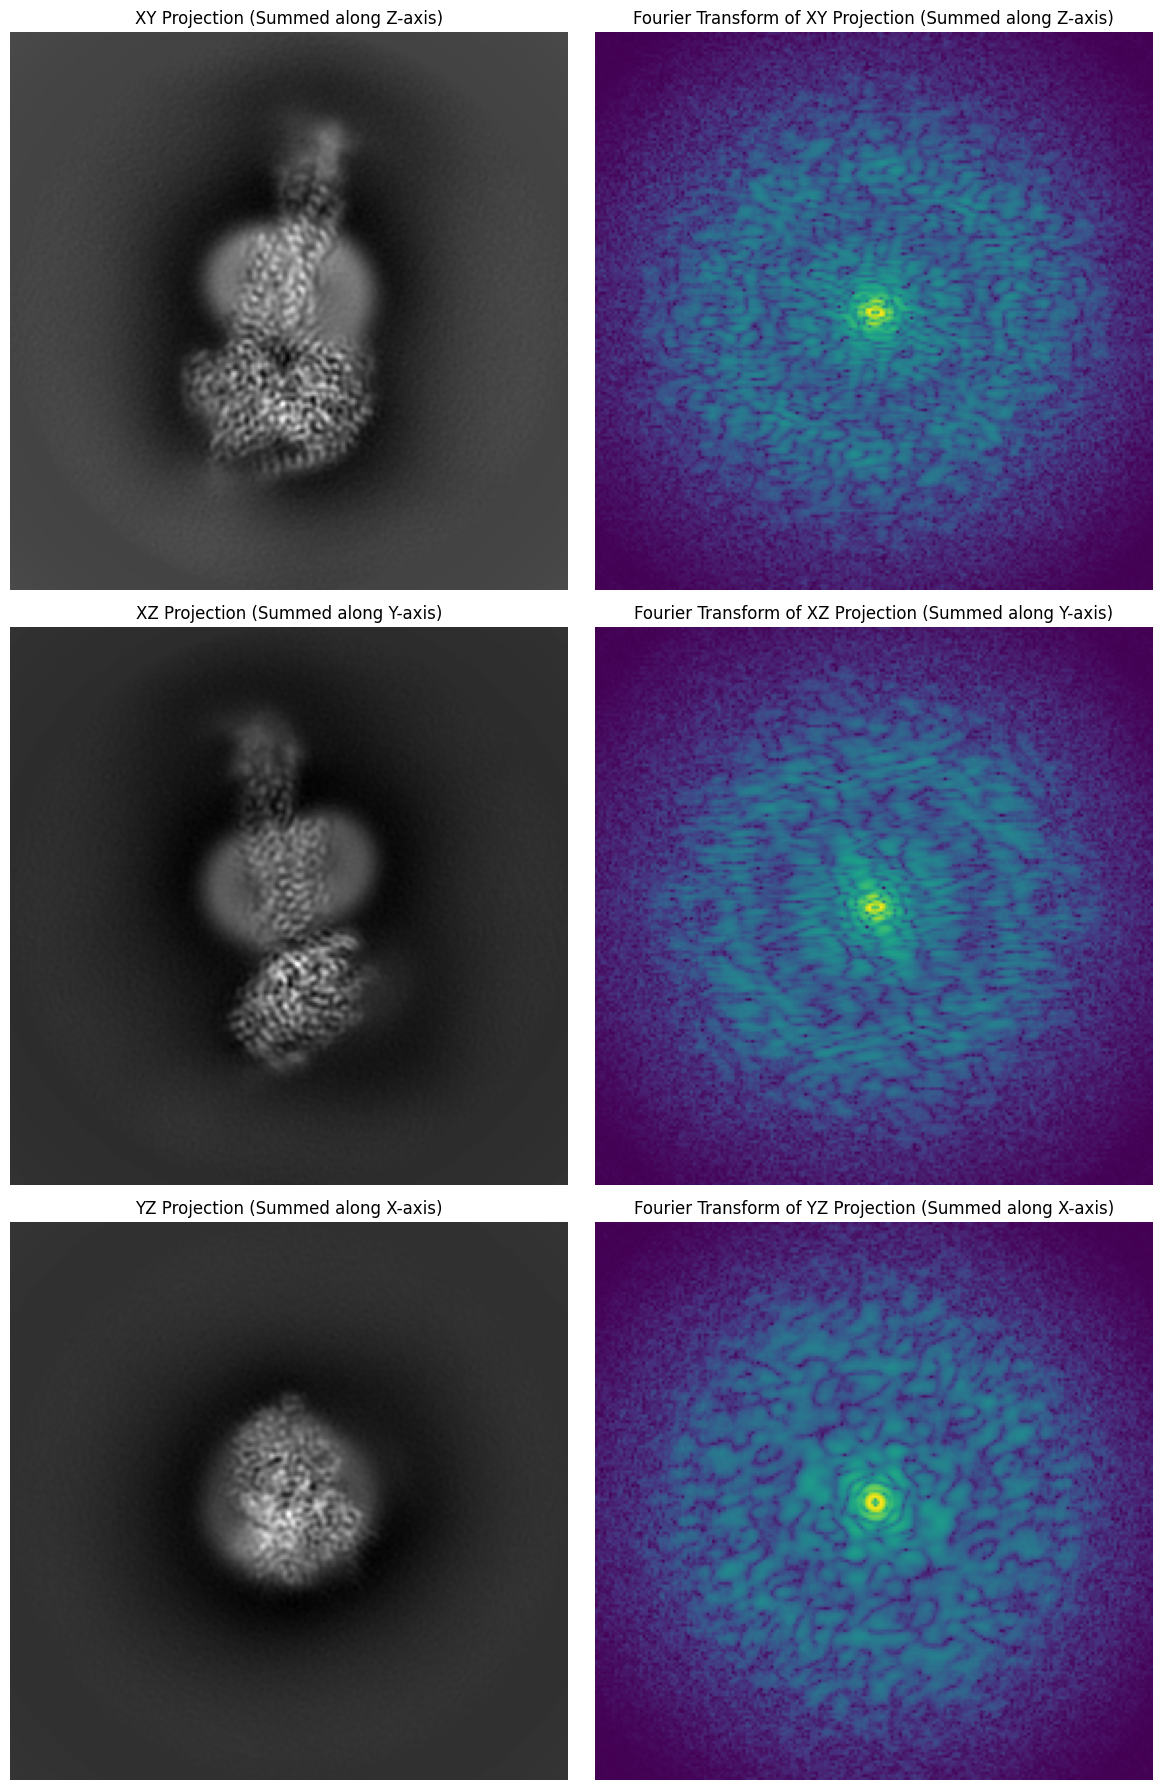

In [1]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

def load_mrc_volume(file_path):
    """Load a 3D volume from an MRC file."""
    with mrcfile.open(file_path, permissive=True) as mrc:
        volume = mrc.data
    return volume

#def back_project_2d(volume, axis=0):
#    """
#    Back-project the 3D volume to a 2D plane.
#    Default: Summing along the first axis (axis=0).
#    """
#    return np.sum(volume, axis=axis)

def back_project_2d(volume):
    """
    Generate three orthogonal back-projections of the 3D volume.
    
    Returns:
        xy_projection: Summation along the z-axis (XY plane).
        xz_projection: Summation along the y-axis (XZ plane).
        yz_projection: Summation along the x-axis (YZ plane).
    """
    xy_projection = np.sum(volume, axis=2)  # Collapse along z-axis
    xz_projection = np.sum(volume, axis=1)  # Collapse along y-axis
    yz_projection = np.sum(volume, axis=0)  # Collapse along x-axis

    return xy_projection, xz_projection, yz_projection


def calculate_fourier_transform(image, crop_size=None):
    """
    Calculate the Fourier transform of a 2D image and optionally crop the result.
    
    Args:
        image: 2D numpy array representing the input image.
        crop_size: Tuple (crop_height, crop_width) specifying the size of the crop.
                   If None, no cropping is applied.

    Returns:
        Cropped Fourier transform (complex values).
    """
    # Compute the Fourier transform and shift the zero-frequency component to the center
    fourier_transform = np.fft.fftshift(np.fft.fft2(image))
    
    if crop_size is not None:
        h, w = fourier_transform.shape
        crop_h, crop_w = crop_size

        # Calculate cropping indices
        start_h = (h - crop_h) // 2
        end_h = start_h + crop_h
        start_w = (w - crop_w) // 2
        end_w = start_w + crop_w

        # Crop the Fourier transform
        fourier_transform = fourier_transform[start_h:end_h, start_w:end_w]

    return fourier_transform


def visualize_results(projections, fourier_transforms):
    """
    Visualize the 2D projections and their Fourier transforms.
    
    Args:
        projections: List of 2D projections.
        fourier_transforms: List of Fourier transforms corresponding to the projections.
    """
    titles = [
        "XY Projection (Summed along Z-axis)",
        "XZ Projection (Summed along Y-axis)",
        "YZ Projection (Summed along X-axis)"
    ]

    fig, axes = plt.subplots(3, 2, figsize=(12, 18))

    for i, (image, fourier_transform) in enumerate(zip(projections, fourier_transforms)):
        # Original Image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(titles[i])
        axes[i, 0].axis('off')

        # Fourier Transform
        magnitude_spectrum = np.log(np.abs(fourier_transform) + 1)
        axes[i, 1].imshow(magnitude_spectrum, cmap='viridis')
        axes[i, 1].set_title(f"Fourier Transform of {titles[i]}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig("BackProjection.png")
    plt.show()


def main():
    # specify FT crop size
    crop_size = (200,200)
    
    # Specify the path to your MRC file
    mrc_file_path = "./volumes/run_class001.mrc"

    # Load the 3D volume
    volume = load_mrc_volume(mrc_file_path)

    # Back-project the volume to 2D (three orthogonal projections)
    xy_projection, xz_projection, yz_projection = back_project_2d(volume)

    # Calculate the Fourier transform for each projection
    fourier_transforms = [
        calculate_fourier_transform(xy_projection, crop_size),
        calculate_fourier_transform(xz_projection, crop_size),
        calculate_fourier_transform(yz_projection, crop_size)
    ]

    # Visualize the results
    visualize_results([xy_projection, xz_projection, yz_projection], fourier_transforms)

if __name__ == "__main__":
    main()


# Central Slices

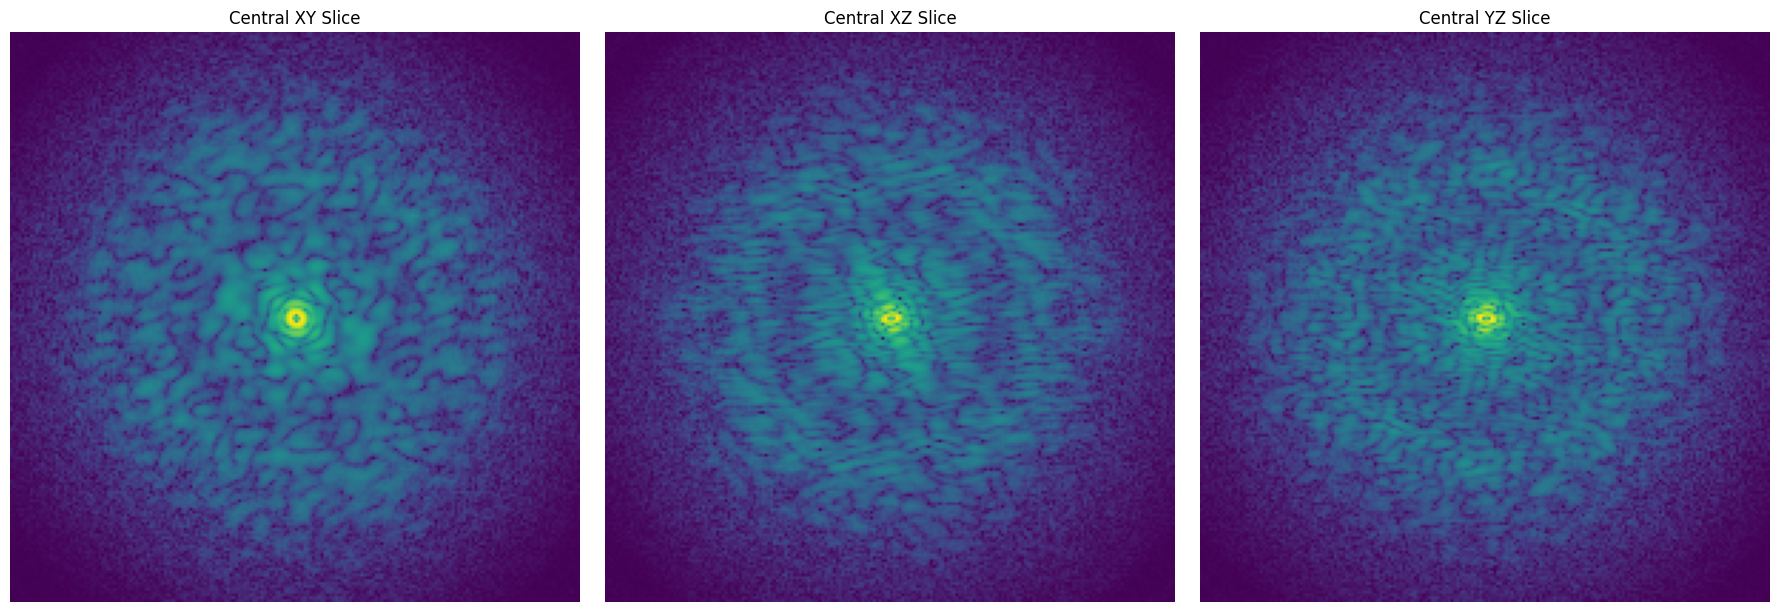

In [2]:
def calculate_3d_fourier_transform(volume):
    """
    Compute the 3D Fourier transform of a 3D volume.
    
    Args:
        volume: 3D numpy array.
    
    Returns:
        3D Fourier transform with zero-frequency component shifted to the center.
    """
    return np.fft.fftshift(np.fft.fftn(volume))

def extract_central_slices(fourier_volume):
    """
    Extract central slices along XY, XZ, and YZ planes from a 3D Fourier transform.
    
    Args:
        fourier_volume: 3D numpy array representing the Fourier-transformed volume.
    
    Returns:
        Tuple of 2D slices (xy_slice, xz_slice, yz_slice).
    """
    # Get the dimensions of the volume
    z, y, x = fourier_volume.shape

    # Central slices
    xy_slice = fourier_volume[z // 2, :, :]  # XY plane: fixed Z
    xz_slice = fourier_volume[:, y // 2, :]  # XZ plane: fixed Y
    yz_slice = fourier_volume[:, :, x // 2]  # YZ plane: fixed X

    return xy_slice, xz_slice, yz_slice

def visualize_central_slices(slices, crop_size=(200,200)):
    """
    Visualize the central slices of the 3D Fourier transform with optional cropping.
    
    Args:
        slices: Tuple of 2D slices (xy_slice, xz_slice, yz_slice).
        crop_size: Tuple (crop_height, crop_width) specifying the size of the cropped region.
                   If None, no cropping is applied.
    """
    titles = ["Central XY Slice", "Central XZ Slice", "Central YZ Slice"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, slice_ in enumerate(slices):
        # Crop the slice if crop_size is specified
        if crop_size is not None:
            crop_height, crop_width = crop_size
            center_y, center_x = slice_.shape[0] // 2, slice_.shape[1] // 2
            y_start = max(center_y - crop_height // 2, 0)
            y_end = min(center_y + crop_height // 2, slice_.shape[0])
            x_start = max(center_x - crop_width // 2, 0)
            x_end = min(center_x + crop_width // 2, slice_.shape[1])
            slice_ = slice_[y_start:y_end, x_start:x_end]

        # Compute the magnitude spectrum for visualization
        magnitude_spectrum = np.log(np.abs(slice_) + 1)  # Log-scaling for better visualization
        axes[i].imshow(magnitude_spectrum, cmap='viridis')
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("FourierCentralSlices.png")
    plt.show()


def main():
    # Define Crop size
    crop_size = (200,200)
    
    # Specify the path to your MRC file
    mrc_file_path = "./volumes/run_class001.mrc"

    # Load the 3D volume
    volume = load_mrc_volume(mrc_file_path)

    # Compute the 3D Fourier transform
    fourier_volume = calculate_3d_fourier_transform(volume)

    # Extract central slices
    central_slices = extract_central_slices(fourier_volume)

    # Visualize the central slices
    visualize_central_slices(central_slices)

if __name__ == "__main__":
    main()




# Demonstrating the Fourier Transform in 1D

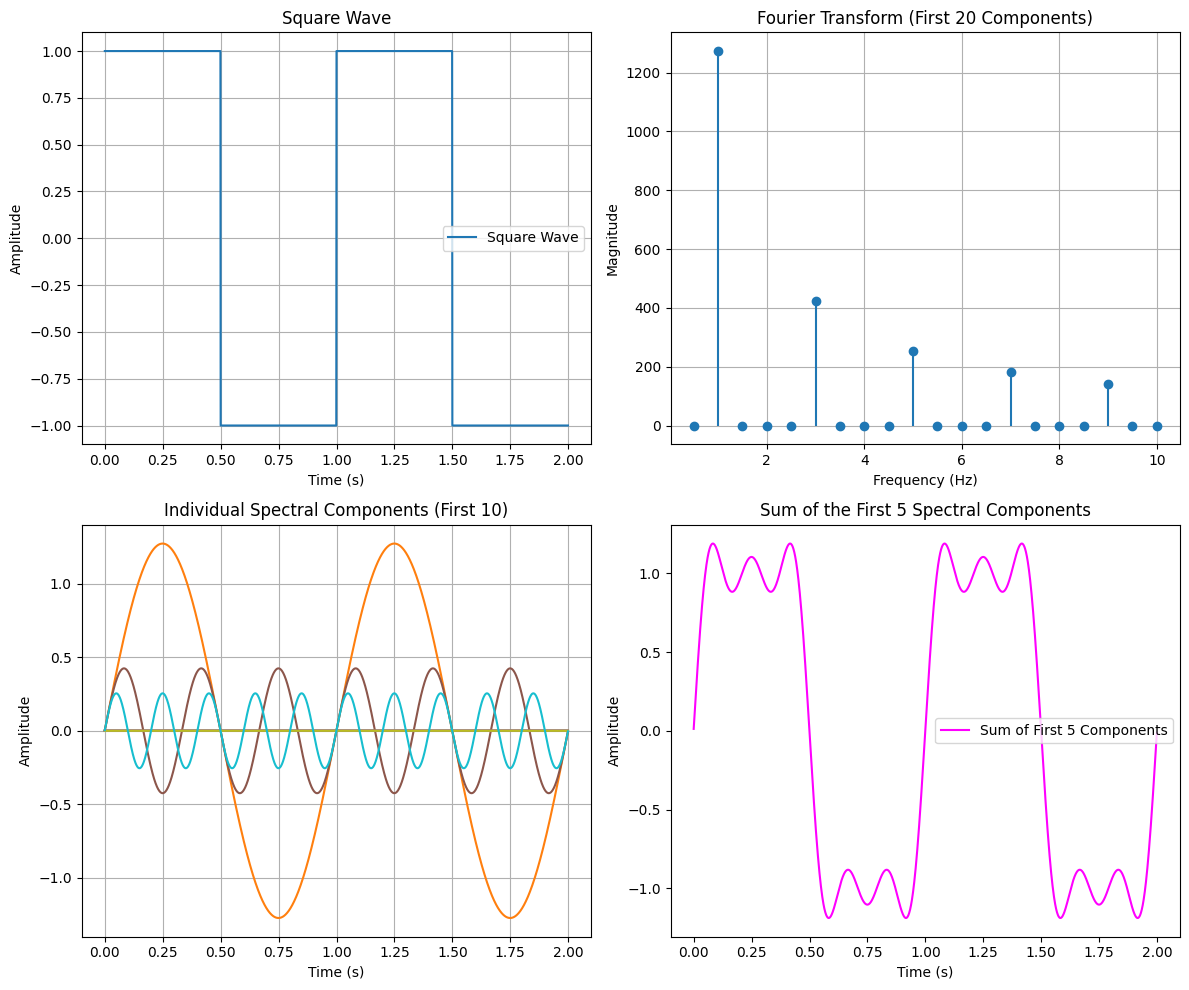

In [3]:
# showing 1D Fourier Transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square

# Parameters
duration = 2  # seconds
sampling_rate = 1000  # Hz
frequency = 1  # Hz of the square wave

# Time vector
t = np.linspace(0, duration, duration * sampling_rate, endpoint=False)

# Generate square wave
sq_wave = square(2 * np.pi * frequency * t)

# Compute Fourier Transform
fft_result = np.fft.fft(sq_wave)
frequencies = np.fft.fftfreq(len(t), d=1/sampling_rate)

# Take only positive frequencies
positive_freqs = frequencies > 0
frequencies = frequencies[positive_freqs]
fft_magnitude = np.abs(fft_result[positive_freqs])

# Reconstruct individual spectral components
components = 10  # Number of spectral components to visualize
reconstructed_signals = []

for k in range(1, components + 1):
    amplitude = 2 * fft_magnitude[k - 1] / len(t)  # Scale amplitude
    phase = np.angle(fft_result[positive_freqs][k - 1])
    sine_wave = amplitude * np.cos(2 * np.pi * frequencies[k - 1] * t + phase)
    reconstructed_signals.append(sine_wave)



# Compute the sum of the first 5 spectral components
sum_first_10 = np.sum(reconstructed_signals[:10], axis=0)


# Plotting in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Original Square Wave (Top-left)
axs[0, 0].plot(t, sq_wave, label="Square Wave")
axs[0, 0].set_title("Square Wave")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)
axs[0, 0].legend()

# Fourier Transform (Top-right)
axs[0, 1].stem(frequencies[:20], fft_magnitude[:20], basefmt=" ")
axs[0, 1].set_title("Fourier Transform (First 20 Components)")
axs[0, 1].set_xlabel("Frequency (Hz)")
axs[0, 1].set_ylabel("Magnitude")
axs[0, 1].grid(True)

# Individual Spectral Components (Bottom-left)
for idx, signal in enumerate(reconstructed_signals[:10], 1):
    axs[1, 0].plot(t, signal, label=f"Component {idx}")
axs[1, 0].set_title("Individual Spectral Components (First 10)")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)
#axs[1, 0].legend()

# Sum of the First 10 Components (Bottom-right)
axs[1, 1].plot(t, sum_first_10, label="Sum of First 5 Components", color="magenta")
axs[1, 1].set_title("Sum of the First 5 Spectral Components")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Amplitude")
#axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.savefig("FourierDecomposition.png")
plt.show()






# Tool for looking at 3D Fourier Transform

In [ ]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from ipywidgets import interact, IntSlider

def load_mrc_volume(file_path):
    """Load a 3D volume from an MRC file."""
    with mrcfile.open(file_path, permissive=True) as mrc:
        volume = mrc.data
    return volume

def calculate_fourier_transform_3d(volume):
    """Calculate the 3D Fourier transform of the volume."""
    return np.fft.fftshift(np.fft.fftn(volume))

def plot_fourier_slice(fourier_volume, axis, index):
    """Plot a slice of the 3D Fourier transform along a given axis."""
    if axis == 0:
        slice_ = fourier_volume[index, :, :]
    elif axis == 1:
        slice_ = fourier_volume[:, index, :]
    elif axis == 2:
        slice_ = fourier_volume[:, :, index]
    
    magnitude_spectrum = np.log(np.abs(slice_) + 1)
    plt.imshow(magnitude_spectrum, cmap='viridis')
    plt.colorbar()
    plt.title(f"Fourier Transform Slice (Axis {axis}, Index {index})")
    plt.show()

def interactive_fourier_slices(fourier_volume):
    """Create interactive sliders to view slices of the 3D Fourier transform."""
    shape = fourier_volume.shape
    interact(lambda axis, index: plot_fourier_slice(fourier_volume, axis, index),
             axis=IntSlider(min=0, max=2, step=1, value=0, description='Axis'),
             index=IntSlider(min=0, max=shape[0]-1, step=1, value=shape[0]//2, description='Index'))

def parallel_fourier_transform(volume):
    """Calculate the 3D Fourier transform in parallel."""
    slices = [volume[i, :, :] for i in range(volume.shape[0])]
    fourier_slices = Parallel(n_jobs=-1)(delayed(np.fft.fft2)(slice_) for slice_ in slices)
    fourier_volume = np.stack(fourier_slices, axis=0)
    return np.fft.fftshift(fourier_volume)

def main():
    # Specify the path to your MRC file
    mrc_file_path = "./volumes/run_class001.mrc"

    # Load the 3D volume
    volume = load_mrc_volume(mrc_file_path)

    # Calculate the 3D Fourier transform in parallel
    fourier_volume = parallel_fourier_transform(volume)

    # View the Fourier transform interactively
    interactive_fourier_slices(fourier_volume)

if __name__ == "__main__":
    main()

interactive(children=(IntSlider(value=0, description='Axis', max=2), IntSlider(value=144, description='Index',…

In [7]:
import mrcfile
import numpy as np
import pyvista as pv

pv.start_xvfb()

def load_mrc_volume(file_path):
    """Load a 3D volume from an MRC file."""
    with mrcfile.open(file_path, permissive=True) as mrc:
        volume = mrc.data
    return volume

def calculate_fourier_transform_3d(volume):
    """Calculate the 3D Fourier transform of the volume."""
    return np.fft.fftshift(np.fft.fftn(volume))

def plot_fourier_transform_3d(fourier_transform):
    """Plot the 3D Fourier transform of a volume interactively using PyVista."""
    magnitude_spectrum = np.log(np.abs(fourier_transform) + 1)

    # Create a PyVista grid
    grid = pv.ImageData()
    grid.dimensions = magnitude_spectrum.shape
    grid.spacing = (1, 1, 1)
    grid.point_data["magnitude"] = magnitude_spectrum.flatten(order="F")

    # Create a PyVista plotter
    plotter = pv.Plotter(notebook=True)
    plotter.add_volume(grid, scalars="magnitude", cmap="viridis", opacity="sigmoid")
    plotter.show()

def main():
    # Specify the path to your MRC file
    mrc_file_path = "/home/mbelouso/src/cryoEM_pythontools/volumes/run_class001.mrc"
    
    # Load the 3D volume
    volume = load_mrc_volume(mrc_file_path)

    # Calculate the 3D Fourier transform
    fourier_transform = calculate_fourier_transform_3d(volume)

    # Plot the 3D Fourier transform interactively
    plot_fourier_transform_3d(fourier_transform)

if __name__ == "__main__":
    main()

Widget(value='<iframe src="http://localhost:36679/index.html?ui=P_0x7426fadf82e0_0&reconnect=auto" class="pyvi…